Name: Tan Yee Yang \
Student ID: 20414203

In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import PIL
from scipy.ndimage import rotate
from skimage import exposure
from skimage.filters import gaussian, frangi
from skimage.morphology import reconstruction, binary_closing, disk

""" Coursework Requirement """
import random   # Not used
random.seed(0)  # Not used

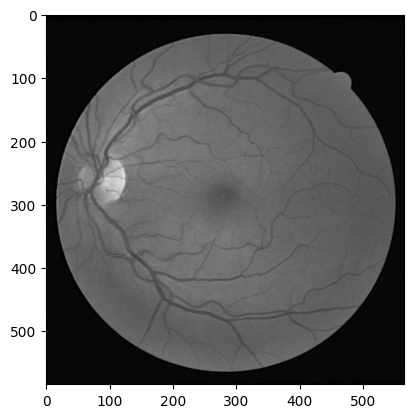

In [3]:
img_path = r'.\retina_images_01_10' # Path to the folder containing the retina images

image_name = '1.tif'                # No. of the retina image to be processed

mask_path = r'.\mask_images'        # Path to the folder containing the mask retina images
mask = PIL.Image.open(os.path.join(mask_path, image_name))  # Open the mask image

label_path = r'.\label_images'      # Path to the folder containing the label retina images
label = PIL.Image.open(os.path.join(label_path, image_name)) # Open the label image

img = cv2.imread(os.path.join(img_path, image_name),cv2.IMREAD_COLOR) # Read the retina image

""" Green Color Channel Selection """
imgGreen = img[:,:,1] # 1 is green channel
plt.imshow(imgGreen,cmap='gray', vmin=0, vmax=255)

[  0 255]
dtype: uint8, shape: (584, 565), min: 0, max: 255


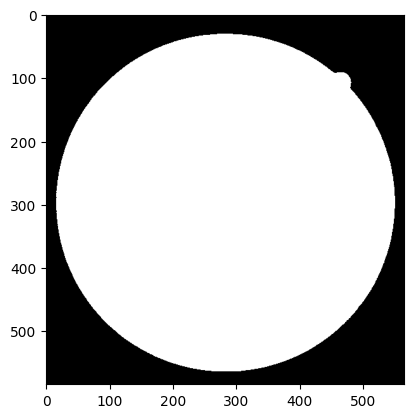

In [4]:
""" Mask Generation """
mask = np.array(mask)
print(np.unique(mask))
print(f'dtype: {mask.dtype}, shape: {mask.shape}, min: {np.min(mask)}, max: {np.max(mask)}')
plt.imshow(mask,cmap='gray', vmin=0, vmax=255)

Invert the green channel image
- Inverted green channel image is obtained by subtracting the green channel image from 255.

Reason:
- The green channel image is inverted because it is easier to see.
- The inverted green channel image also yields a minor performance improvement after experimentation.


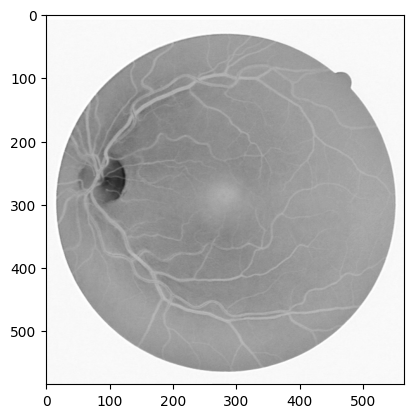

In [5]:
""" Green Channel Inversion"""
inverted_imgGreen = 255 - img[:,:,1] # invert the green channel image, where the blood vessel appear brighter than background
plt.imshow(inverted_imgGreen,cmap='gray', vmin=0, vmax=255)

Contrast Limited Adaptive Histogram Equalization (CLAHE)
- For contrast enhancement

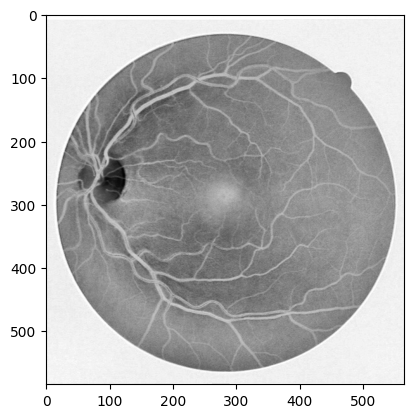

In [6]:
""" Contrast Limited Adaptive Histogram Equalization (CLAHE) """
# Function to apply CLAHE to the image
def apply_CLAHE(image, clipLimit=2.0, tileGridSize=(5,5)):
    clahe = cv2.createCLAHE(clipLimit, tileGridSize)
    clahe_image = clahe.apply(image)
    
    return clahe_image

# Apply CLAHE to the grayscale image
clahe_inverted_green_image = apply_CLAHE(inverted_imgGreen, clipLimit=1.55, tileGridSize=(7,7))
plt.imshow(clahe_inverted_green_image, cmap='gray')

Gaussian Smoothing
- To remove noise generated by the CLAHE

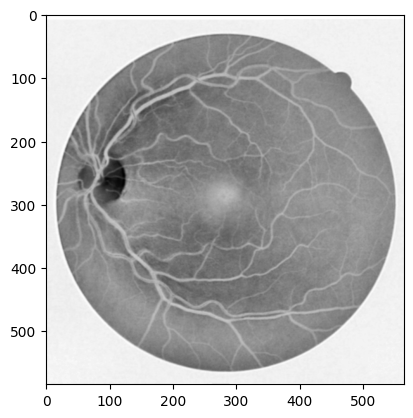

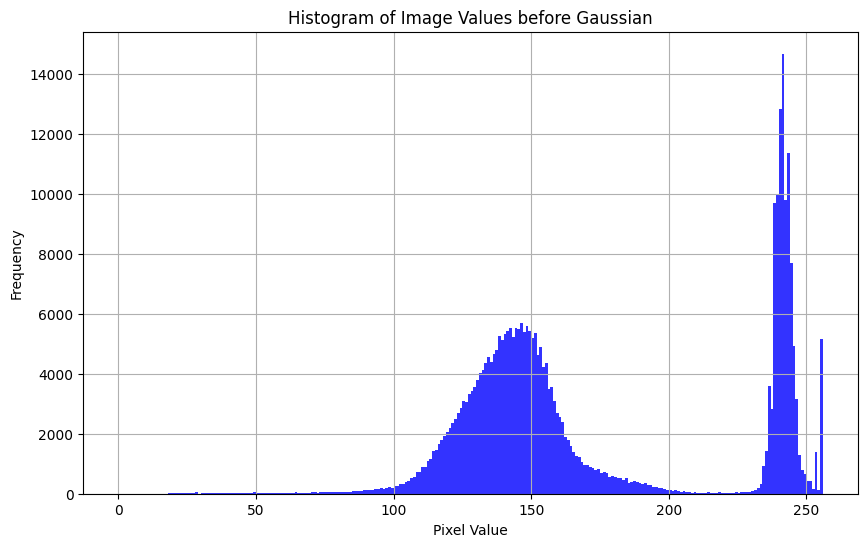

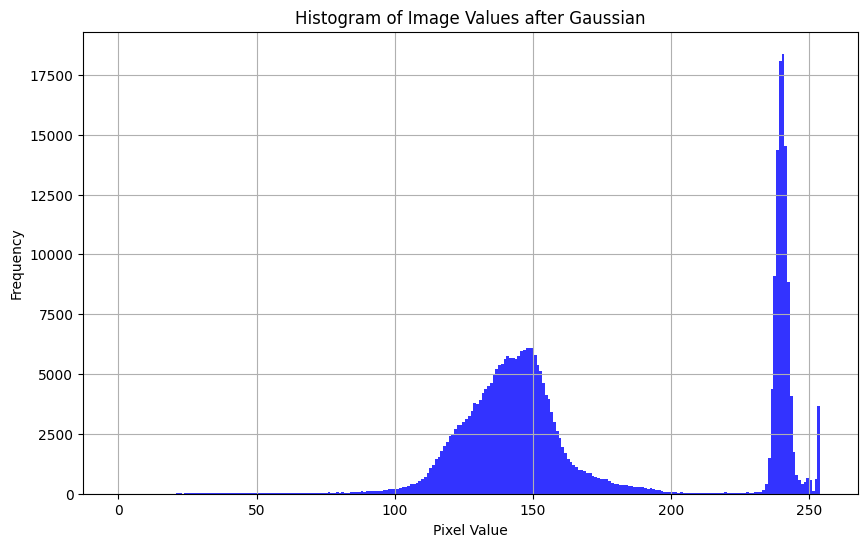

In [7]:
""" Gaussian Smoothing """
# Function to apply Gaussian Smoothing to the image
def apply_Gaussian(image):
    # Apply Gaussian Blur
    sigma = 0.8
    truncate = 3 * sigma**2
    blurred_imgGreen = gaussian(image, sigma=sigma, truncate=truncate)
    
    # Rescale the blurred image back to 0-255
    blurred_imgGreen = (blurred_imgGreen * 255).astype('uint8')
    
    return blurred_imgGreen

blurred_inverted_imgGreen = apply_Gaussian(clahe_inverted_green_image)

plt.imshow(blurred_inverted_imgGreen, cmap='gray')

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(clahe_inverted_green_image.ravel(), bins=256, range=(0,256), color='blue', alpha=0.8)
plt.title('Histogram of Image Values before Gaussian')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(blurred_inverted_imgGreen.ravel(), bins=256, range=(0,255), color='blue', alpha=0.8)
plt.title('Histogram of Image Values after Gaussian')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Top-Hat Filtering
- Vessel enhancement

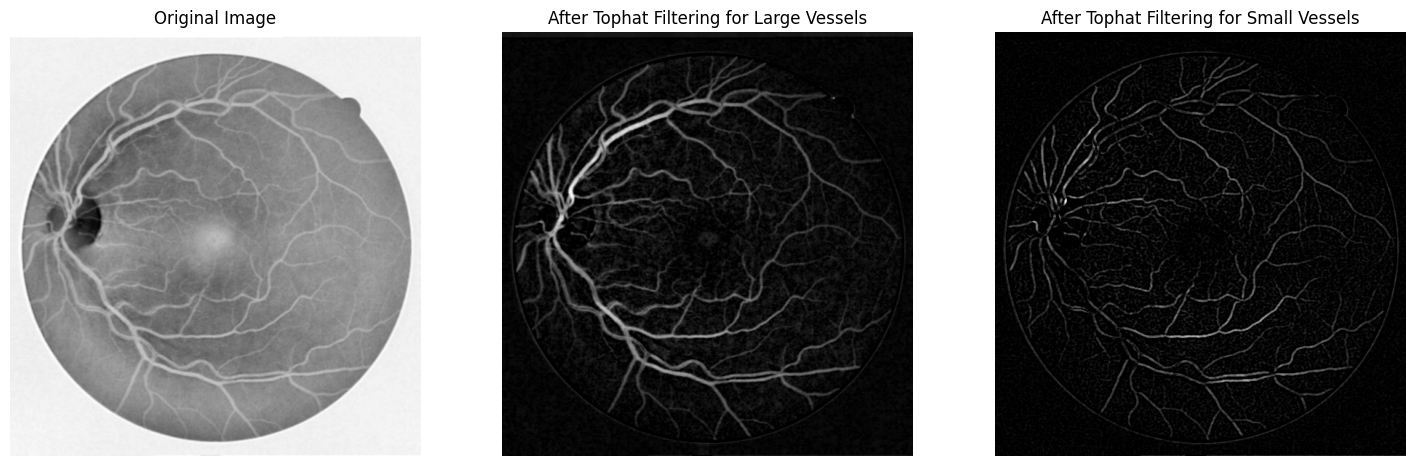

In [8]:
""" White Tophat Filtering """
# Function to apply white tophat filtering
def apply_tophat(image, kernel_size):
    # Define the disk-shaped structuring element, large kernel size detect large and vice versa
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    tophat = cv2.morphologyEx(image, cv2.MORPH_TOPHAT, kernel)  # Apply white tophat filtering
    return tophat

tophat_largeVessel = apply_tophat(blurred_inverted_imgGreen, 19)    # Large vessels
tophat_smallVessel = apply_tophat(blurred_inverted_imgGreen, 5)     # Small vessels

# Display the original and tophat images
plt.figure(figsize=(18, 9))
plt.subplot(1, 3, 1)
plt.imshow(blurred_inverted_imgGreen, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(tophat_largeVessel, cmap='gray')
plt.title('After Tophat Filtering for Large Vessels')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(tophat_smallVessel, cmap='gray')
plt.title('After Tophat Filtering for Small Vessels')
plt.axis('off')

plt.show()

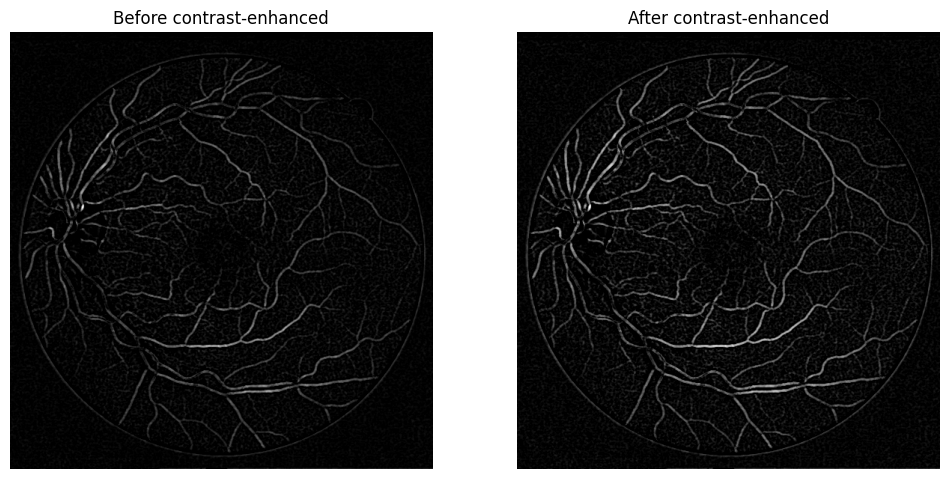

In [9]:
# Apply CLAHE to the tophat images for contrast enhancement
tophat_small_vessel_contrast_enhanced = apply_CLAHE(tophat_smallVessel, clipLimit=0.965, tileGridSize=(5, 5))

# Set up a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Display the original, contrast-enhanced image
axs[0].imshow(tophat_smallVessel, cmap='gray')
axs[0].set_title('Before contrast-enhanced')
axs[0].axis('off')  # Hide axis labels and ticks

# Display the normalized image
axs[1].imshow(tophat_small_vessel_contrast_enhanced, cmap='gray')
axs[1].set_title('After contrast-enhanced')
axs[1].axis('off')  # Hide axis labels and ticks

plt.show()

Frangi Filter
- To enhance the small blood vessels

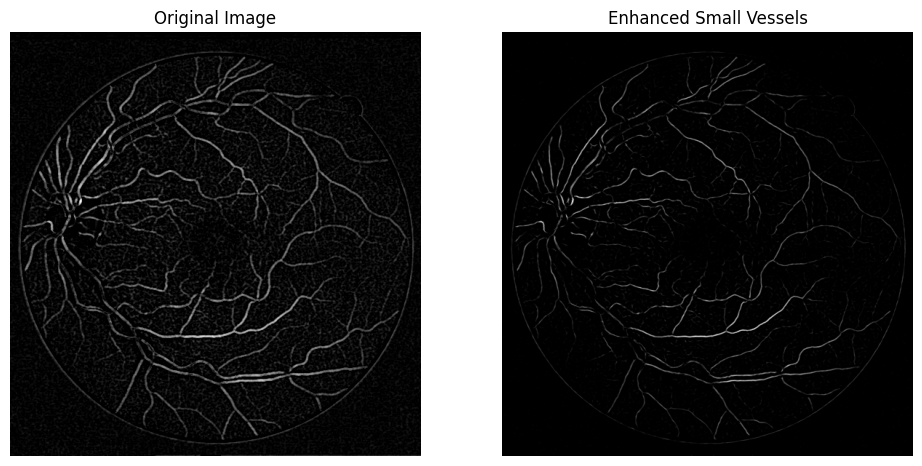

In [10]:
""" Frangi Filter """
def apply_frangi_filter(image, sigmas, alpha, beta):
    """
    Apply the Frangi filter with the specified sigma values
    - alpha: sensitivity to deviation from plate-like structure
    - beta: sensitivity to deviation from a blob like structure
    - minimum scale: specifies the smallest vessel diameter the filter should detect
    - maximim scale: sensitivity to the largest vessel diameter
    - step size: determines how many different scales (i.e., vessel sizes) the filter examines between the minimum and maximum.
    """
    enhanced_image = frangi(image, sigmas=sigmas, alpha=alpha, beta=beta, black_ridges=False)   # Apply Frangi filter
        
    # Normalize the enhanced image to 0-255
    min_val = np.min(enhanced_image)
    max_val = np.max(enhanced_image)
    
    scaled_image = 255 * (enhanced_image - min_val) / (max_val - min_val)
    scaled_image = scaled_image.astype(np.uint8)

    return scaled_image

# Define parameters for two different vessel sizes
small_vessel_sigmas = (0.8535, 2, 0.001)

# Apply Frangi filter to enhance different vessel sizes
small_vessel_scaled_enhanced_image = apply_frangi_filter(tophat_small_vessel_contrast_enhanced, small_vessel_sigmas, alpha=1, beta=13)

# Display the original and enhanced images
plt.figure(figsize=(18, 9))
plt.subplot(1, 3, 1)
plt.imshow(tophat_small_vessel_contrast_enhanced, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(small_vessel_scaled_enhanced_image, cmap='gray')
plt.title('Enhanced Small Vessels')
plt.axis('off')

plt.show()

Mean-C Thresholding

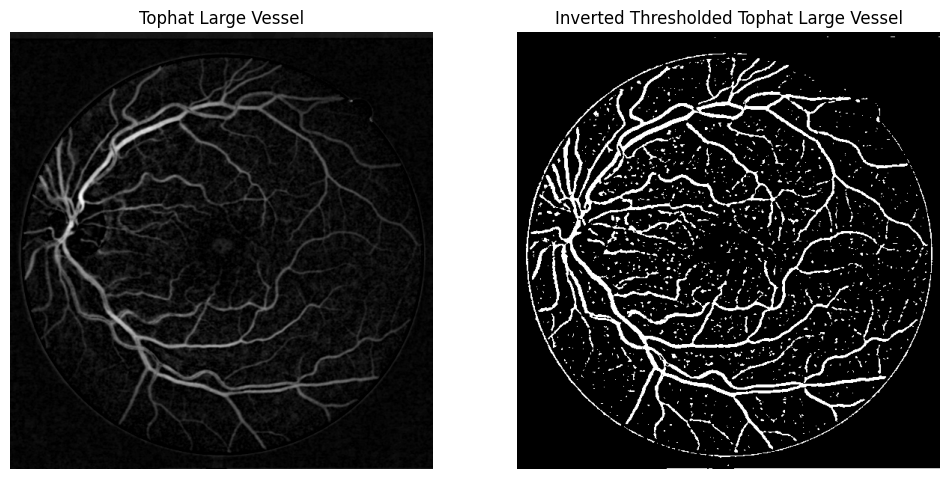

In [11]:
""" Mean-C Thresholding """
# Function to calculate the optimal C value for mean-C thresholding and apply the thresholding
def mean_c_thresholding(image, window_size, C):
    # Apply mean-C thresholding with the determined optimal values
    C = C * 255  # Optimal C value scaled to 0-255 range

    """ Use a mean filter """    
    # Step a: Create a mean filter kernel
    kernel = np.ones((window_size, window_size), np.float32) / (window_size ** 2)
    
    # Step b: Convolve the image with the mean filter
    img_mean_filtered = cv2.filter2D(image, -1, kernel)
    
    # Step c: Calculate the difference image
    img_diff = cv2.subtract(image, img_mean_filtered)
    
    # Step d: Threshold the difference image with the constant value C
    _, img_thresholded = cv2.threshold(img_diff, C, 255, cv2.THRESH_BINARY)
    
    # Step e: Calculate the complement of the thresholded image
    img_complement = cv2.bitwise_not(img_thresholded)
    
    # inverting the image
    inverted_img_complement = 255 - img_complement

    return inverted_img_complement


# Apply mean-C thresholding (For Large Vessels)
mean_c_thresholded_largeVessel = mean_c_thresholding(tophat_largeVessel, 13, 0.02)

# Plot out the images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(tophat_largeVessel, cmap='gray')
plt.title('Tophat Large Vessel')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mean_c_thresholded_largeVessel, cmap='gray')
plt.title('Inverted Thresholded Tophat Large Vessel')
plt.axis('off')

plt.show()

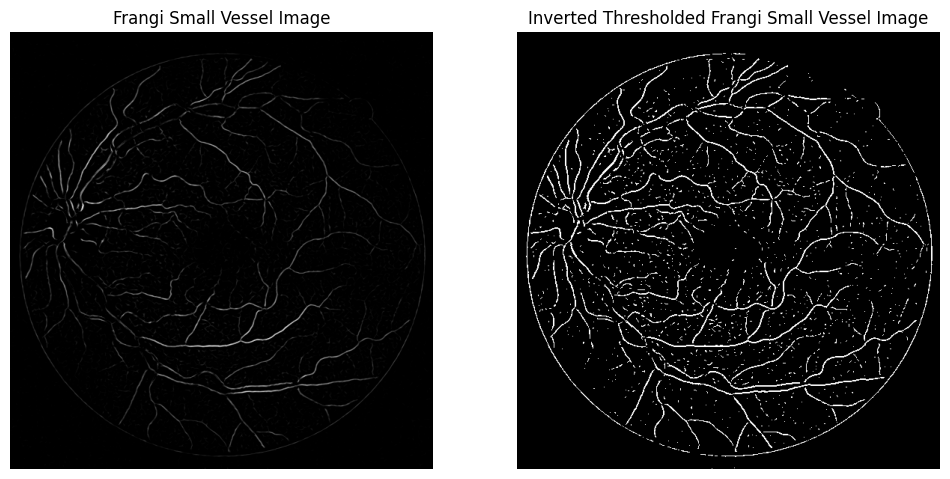

In [12]:
# Apply mean-C thresholding (For Small Vessels)
mean_c_thresholded_smallVessel = mean_c_thresholding(small_vessel_scaled_enhanced_image, 7, 0.04)

# Plot out the images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(small_vessel_scaled_enhanced_image, cmap='gray')
plt.title('Frangi Small Vessel Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(mean_c_thresholded_smallVessel, cmap='gray')
plt.title('Inverted Thresholded Frangi Small Vessel Image')
plt.axis('off')

plt.show()

Morphological Processing
- To remove the noise generated after thresholding

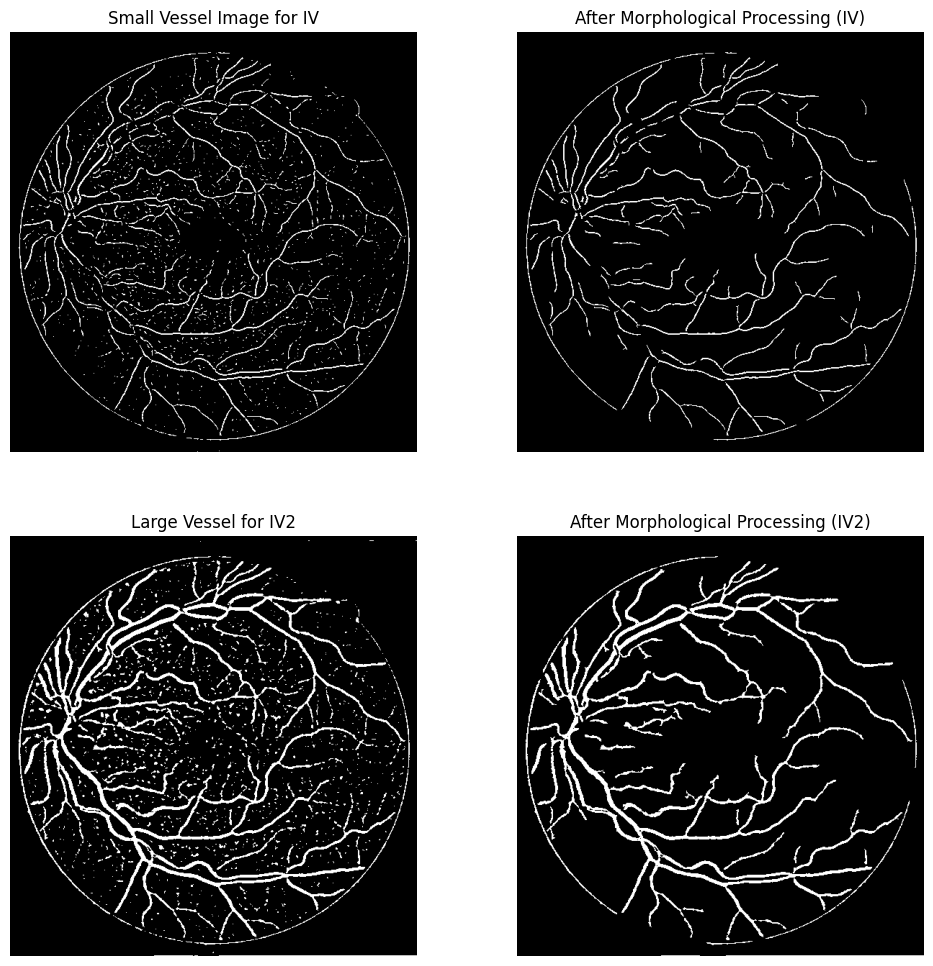

In [13]:
""" Morphological Processing """
# Function to create a linear structuring element
def create_structuring_element(length, angle, width=1):
    """
    Create a linear structuring element with the given length, angle, and width.
    """
    element = np.zeros((length, length))
    radians = np.deg2rad(angle)
    x_center, y_center = length // 2, length // 2
    for x in range(length):
        for y in range(length):
            x_shifted, y_shifted = x - x_center, y - y_center
            x_rotated = x_shifted * np.cos(radians) + y_shifted * np.sin(radians)
            y_rotated = -x_shifted * np.sin(radians) + y_shifted * np.cos(radians)
            if abs(x_rotated) < width / 2.0 and abs(y_rotated) < length / 2.0:
                element[y, x] = 1
    return element.astype(np.uint8)  # Convert to uint8

# Function to perform morphological processing
def morphological_processing(image, L1, L2):
    angles = np.arange(0, 180, 15)  # 0° to 165°, 12 angles
    openings_L1 = []
    openings_L2 = []

    for angle in angles:
        struct_elem_L1 = create_structuring_element(L1, angle)
        struct_elem_L2 = create_structuring_element(L2, angle, width=1)
        opening_L1 = cv2.morphologyEx(image, cv2.MORPH_OPEN, struct_elem_L1)
        opening_L2 = cv2.morphologyEx(image, cv2.MORPH_OPEN, struct_elem_L2)
        openings_L1.append(opening_L1)
        openings_L2.append(opening_L2)

    # Taking the supremum of openings for L1 (preserving linear shapes)
    Ic = np.maximum.reduce(openings_L1)
    
    # Morphological reconstruction to improve Ic
    marker = Ic.astype(np.uint8)
    mask = image
    Ic_reconstructed = reconstruction(marker, mask, method='dilation')
    
    # Taking the infimum of openings for L2 (removing linear shapes)
    IB = np.minimum.reduce(openings_L2)

    # Subtracting the two images to get only the linear shapes
    IV = Ic_reconstructed - IB
    
    return IV

"""
Process the image
    - L1: Length of the structuring element for preserving linear shapes
    - L2: Length of the structuring element for removing linear shapes
"""
IV = morphological_processing(mean_c_thresholded_smallVessel, 10, 15)
IV2 = morphological_processing(mean_c_thresholded_largeVessel, 17, 10)

plt.figure(figsize=(12, 12))

plt.subplot(2, 2, 1)
plt.imshow(mean_c_thresholded_smallVessel, cmap='gray')
plt.title('Small Vessel Image for IV')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(IV, cmap='gray')
plt.title('After Morphological Processing (IV)')
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(mean_c_thresholded_largeVessel, cmap='gray')
plt.title('Large Vessel for IV2')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(IV2, cmap='gray')
plt.title('After Morphological Processing (IV2)')
plt.axis('off')

plt.show()

Bitwise OR Opeartion
- Use to merge the large vessel image and small vessel image together.

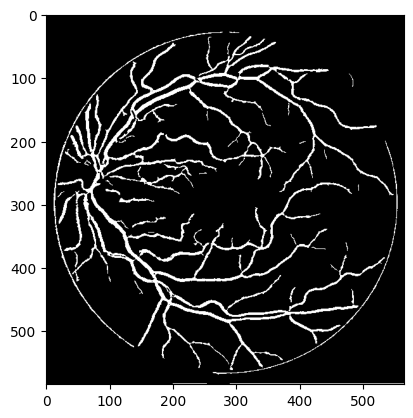

In [14]:
""" Bitwise OR Operation """
# Merge the large and small vessel images
merged_image = cv2.bitwise_or(IV/255, IV2/255) 
plt.imshow(merged_image, cmap='gray', vmin=0, vmax=1)

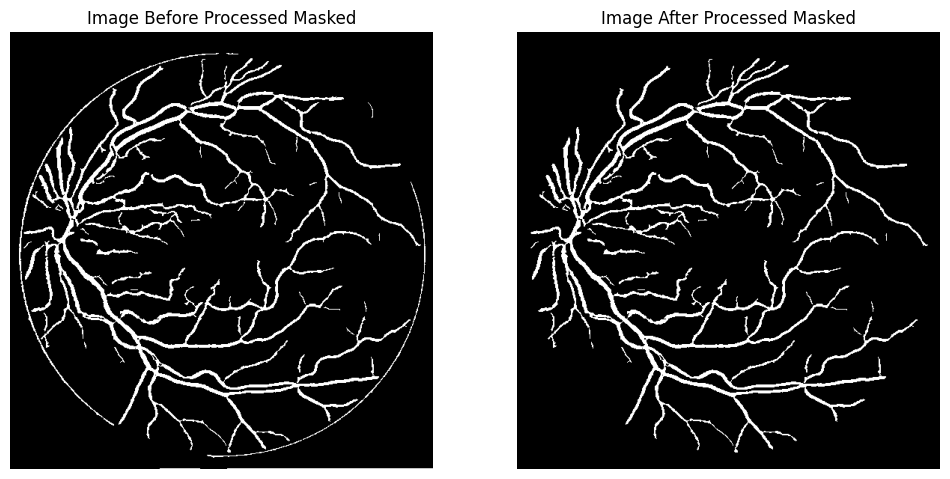

In [15]:
""" Processed Masked Image """
merged_masked_image = np.multiply(merged_image, mask/255)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(merged_image, cmap='gray')
plt.title('Image Before Processed Masked')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(merged_masked_image, cmap='gray')
plt.title('Image After Processed Masked')
plt.axis('off')

plt.show()

[0 1]


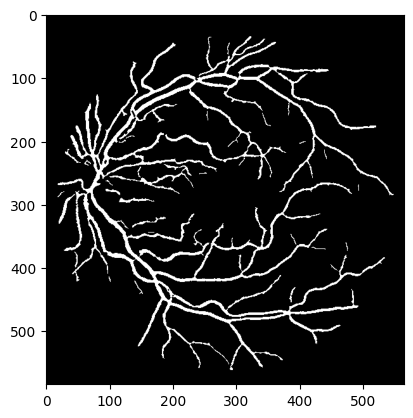

In [16]:
""" Morphological Closing """
# Function to apply morphological closing
def apply_morphological_closing(image):
    # Define the structural element
    structure_element = disk(1)
    
    # Apply morphological closing operation
    closed_image = binary_closing(image, structure_element)
    
    # Turn to binary image
    closed_image_binary = closed_image.astype(np.uint8)
    return closed_image_binary

thres_DoG = apply_morphological_closing(merged_masked_image)
print(np.unique(thres_DoG))
plt.imshow(thres_DoG, cmap='gray', vmin=0, vmax=1)

P: 0.7567999456004352
N: 0.9760110789115995
T: 0.9472762359778408


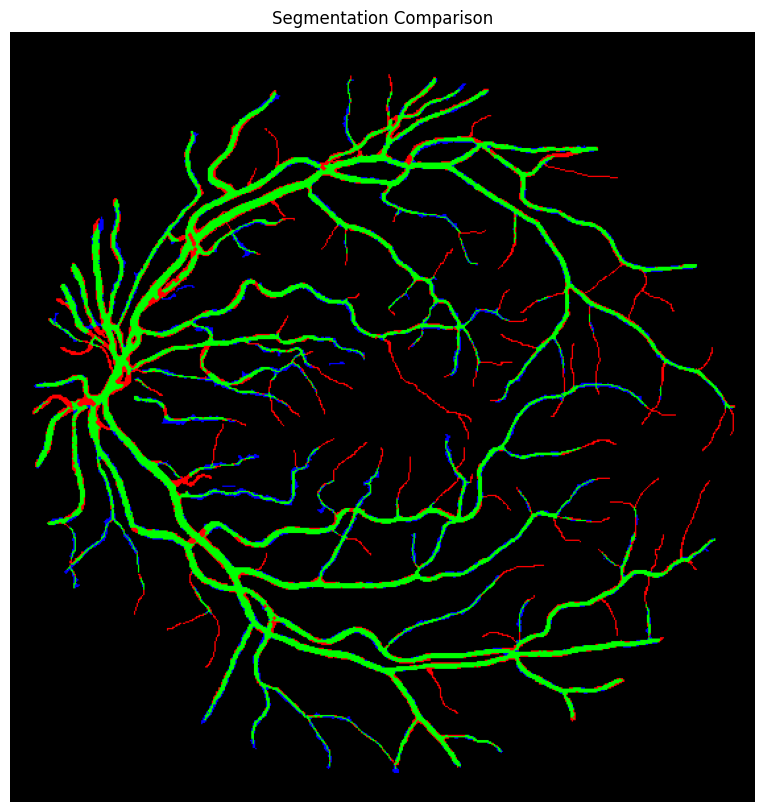

In [17]:
label = np.array(label)

TP = sum(sum((label==255) & (thres_DoG==1) & (mask == 255)))
TN = sum(sum((label==0) & (thres_DoG==0) & (mask == 255)))
FP = sum(sum((label==0) & (thres_DoG==1) & (mask == 255)))
FN = sum(sum((label==255) & (thres_DoG==0) & (mask == 255)))
P = TP/(TP+FN)
N = TN/(TN+FP)
T = (TP+TN)/(TP+FN+TN+FP)
print(f'P: {P}')
print(f'N: {N}')
print(f'T: {T}')

# Visualization of differences
visualization = np.zeros(label.shape + (3,), dtype=np.uint8)
visualization[..., 0] = ((label == 255) & (thres_DoG == 0) & (mask == 255)) * 255  # FN in Red
visualization[..., 1] = ((label == 255) & (thres_DoG == 1) & (mask == 255)) * 255  # TP in Green
visualization[..., 2] = ((label == 0) & (thres_DoG == 1) & (mask == 255)) * 255  # FP in Blue

# Show the result
plt.figure(figsize=(10, 10))
plt.imshow(visualization)
plt.title('Segmentation Comparison')
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Red: Areas th segmentation missed but should have included.
# Green: Areas correctly identified by the segmentation.
# Blue: Areas wrongly marked by the segmentation that should not have been included.

# 0.9471202485103197

In [18]:
img_path_1 = r'.\retina_images_01_10'
img_path_2 = r'.\retina_images_11_20'
mask_path = r'.\mask_images'
label_path = r'.\label_images'

P_total, N_total, T_total = 0., 0., 0.

for i in range(1, 21):
    # Load input image
    if i < 11:
        img = cv2.imread(os.path.join(img_path_1,str(i)+'.tif'),cv2.IMREAD_COLOR)
    else:
        img = cv2.imread(os.path.join(img_path_2,str(i)+'.tif'),cv2.IMREAD_COLOR)
        
    # Select the green channel of the retina blood vessel image
    imgGreen = img[:,:,1]

    # Invert the green channel image, where the blood vessel appear brighter than background
    inverted_imgGreen = 255 - img[:,:,1] 

    # Apply CLAHE to the Grayscale Image
    clahe_inverted_image = apply_CLAHE(inverted_imgGreen, clipLimit=1.55, tileGridSize=(7,7))
    
    # Apply Gaussian Smoothing
    blurred_inverted_imgGreen = apply_Gaussian(clahe_inverted_image)

    # Apply White Tophat Filtering
    tophat_largeVessel = apply_tophat(blurred_inverted_imgGreen, 19)
    tophat_smallVessel = apply_tophat(blurred_inverted_imgGreen, 5)

    # Apply CLAHE to the tophat images for contrast enhancement
    tophat_small_vessel_contrast_enhanced = apply_CLAHE(tophat_smallVessel, clipLimit=0.965, tileGridSize=(5, 5))

    # Define parameters for the thin vessel sizes
    small_vessel_sigmas = (0.8535, 2, 0.001)

    # Apply Frangi filter to enhance the thin vessels
    small_vessel_scaled_enhanced_image = apply_frangi_filter(tophat_small_vessel_contrast_enhanced, small_vessel_sigmas, alpha=1, beta=13)

    # Apply Mean-C Thresholding
    mean_c_thresholded_largeVessel = mean_c_thresholding(tophat_largeVessel, 13, 0.02)                # Large vessels
    mean_c_thresholded_smallVessel = mean_c_thresholding(small_vessel_scaled_enhanced_image, 7, 0.04) # Small vessels

    # Apply Morphological Processing to the Mean-C Thresholded Image
    IV_large = morphological_processing(mean_c_thresholded_largeVessel, 17, 20)     # Large vessels
    IV_small = morphological_processing(mean_c_thresholded_smallVessel, 10, 15)     # Small vessels

    # Merge the large and small vessel images
    merged_image = cv2.bitwise_or(IV_large/255, IV_small/255)

    # Load and Preprocess the mask
    mask = np.array(PIL.Image.open(os.path.join(mask_path,str(i)+'.tif')))
    merged_masked_image = np.multiply(merged_image, mask/255)

    # Apply morphological closing
    thres_DoG = apply_morphological_closing(merged_masked_image)

    # Load the label
    label = np.array(PIL.Image.open(os.path.join(label_path,str(i)+'.tif')))
    
    TP = sum(sum((label==255) & (thres_DoG==1) & (mask == 255)))
    TN = sum(sum((label==0) & (thres_DoG==0) & (mask == 255)))
    FP = sum(sum((label==0) & (thres_DoG==1) & (mask == 255)))
    FN = sum(sum((label==255) & (thres_DoG==0) & (mask == 255)))

    P = TP/(TP+FN)
    N = TN/(TN+FP)
    T = (TP+TN)/(TP+FN+TN+FP)

    # print(f'Image {i}')
    # print(f'P: {P}')
    # print(f'N: {N}')
    # print(f'T: {T}')
    
    P_total += TP/(TP+FN)
    N_total += TN/(TN+FP)
    T_total += (TP+TN)/(TP+FN+TN+FP)

print('P Average: ', P_total/20)
print('N Average: ', N_total/20)
print('T Average: ', T_total/20)

# Best Results:
# T Average:  0.9414566746811268

P Average:  0.6800431569574709
N Average:  0.9798654186652881
T Average:  0.9414566746811268
